# Low luminosity transient searches

This notebook is prepared by Viraj Karambelkar (vk2588@columbia.edu) for the LSST CCA Summer School 2025, conducted at the Center for Computational Astrophysics from July 28 to August 8, 2025.

## Introduction
This module demonstrates how to study low-luminosity transients using time-domain surveys.

In this notebook, we will first review the landscape of low-luminosity transients, and attempt to find a low-luminosity transient by filtering through real ZTF alerts. We will look at examples of filtering alert streams to find candidate transients, followed by cross-matching with galaxy catalogs to identify potential host galaxies and estimate the absolute magnitudes of the candidates, and leverage the photometric properties to identify the transient of interest.  Finally, we will look at how archival photometric data can be used to study precursor emission and identify progenitors of transients in nearby galaxies.

## Learning Objectives
- Understand the landscape of low-luminosity transients
- Filter alert streams to find candidate low-luminosity transients
- Explore galaxy catalogs to identify potential host galaxies
- Use color and lightcurve information to examine the diversity of low luminosity transients.
- Understand how archival data can be used to study precursor emission and identify the progenitors of transients in nearby galaxies

This notebook can be done alone or in groups. However, there are three breakout discussion activities that you should do in groups, and discuss your findings with everyone.

## Required packages
pandas <br>
alerce <br>
astropy <br>
psycopg <br>
tqdm <br>
matplotlib <br>
astroquery <br>
numpy <br>
matplotlib <br>
emcee <br>
corner <br>

If you already have these packages installed, try executing the next cell - if you get no errors, your imports are likely good to go. If not, try installing these preferred versions with `pip`.

Preferred versions : <br>
numpy >=2.0.0 <br>
matplotlib>=3.10.0 <br>
astropy >= 7.0.0 <br>
pandas >= 2.2.1 <br>
psycopg == 3.2.9 <br>
astroquery == 0.4.10 <br>
tqdm == 4.67.1 <br>
emcee == 3.1.6 <br>
corner == 2.2.3 <br>


## External files
Provided in the files subdirectory
- `landscape.jpg` : A luminosity-timescale plot from Cai et al. 2022
- `mist_tracks/` : MIST stellar evolutionary tracks
- `glade_galaxies.csv` : Downloaded GLADE galaxies, in case online query fails
- `all_ztf_alerts.csv` : Downloaded ZTF alerts, in case online query fails

In [3]:
import pandas as pd
from alerce.core import Alerce
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
import psycopg
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from astropy.io import ascii
import matplotlib
import emcee
from astropy.modeling.physical_models import BlackBody
import corner


def init():
    """
    A function to set matplotlib parameters so the plots look decent.
    """
    matplotlib.rcParams['xtick.minor.size'] = 6
    matplotlib.rcParams['xtick.major.size'] = 8
    matplotlib.rcParams['ytick.major.size'] = 8
    matplotlib.rcParams['ytick.minor.size'] = 6
    matplotlib.rcParams['lines.linewidth'] = 1.0
    matplotlib.rcParams['axes.linewidth'] = 1.0
    matplotlib.rcParams['font.size']= 18
    matplotlib.rcParams['font.family']= 'sans-serif'
    matplotlib.rcParams['xtick.major.width']= 1.5
    matplotlib.rcParams['ytick.major.width']= 1.5
    matplotlib.rcParams['ytick.direction']='in'
    matplotlib.rcParams['xtick.direction']='in'

init()

## 1. The landscape of low luminosity transients

Here is a luminosity-timescale plot (from [Cai et al. 2022](https://www.mdpi.com/2218-1997/8/10/493))

![Luminosity timescale plot](files/landscape.jpg)


In this module, we will focus on transients with peak absolute magnitudes lower than -16 and that are not necessarily fast (i.e. $\tau_{\rm{0.1dex}}>10$ days). This includes the following classes of transients ---

- Luminous Red Novae (LRNe): believed to be stellar mergers of massive stars.
- Intermediate Luminosity Red Transients (ILRTs): Unclear origins, possibly electron-capture supernovae in AGB stars.
- Luminous Blue Variable (LBV) outbursts : Massive stars undergoing outbursts.
- Classical novae : Have the lowest luminosities in this category, and are thermonuclear explosions on the surface of white dwarfs.
- Low luminosity core-collapse supernovae : Unclear origins, possibly representing explosions of the lowest mass stars that can undergo core-collapse.
- Low luminosity Type Iax supernovae : Unusual thermonuclear supernovae that are believed to originate from partial deflagrations of accreting white dwarfs that do not fully detonate the white dwarf.
- Calcium-rich transients : Unclear origins, show unusually strong calcium emission lines in their spectra.
- Other theoretically supported transients that are yet to be observationally confirmed, such as electron-capture supernovae, direct collapse of a star to a black hole, and so on.

Let's understand the detectability horizons for these transients.

Problem 1 : Plot the detection horizon distance (i.e. maximum distance out to which a transient can be detected) as a function of its r-band absolute magnitude, for ZTF (limiting magnitude = 20.5 mag) and LSST (limiting magnitude = 24 mag). Keep in mind milestone-distances of the Magellanic Clouds (~ 50 kpc), M31 (~ 1 Mpc), and the Virgo Cluster (~ 20 Mpc). Examine the differences in detectability between ZTF and LSST.

In [ ]:
abs_mags = np.linspace(-6, -16, 50)
ztf_lim_mag = 20.5
lsst_lim_mag = 24.0

ztf_distmod = ztf_lim_mag - abs_mags
lsst_distmod = lsst_lim_mag - abs_mags

ztf_dist = 10**((ztf_distmod + 5.) / 5.) / 1e6
lsst_dist = 10**((lsst_distmod + 5.) / 5.) / 1e6


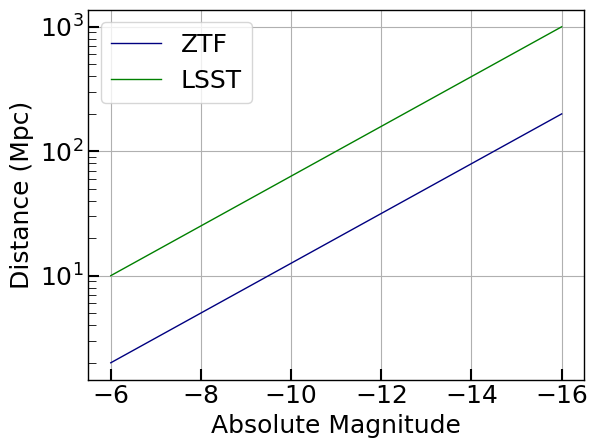

In [31]:
plt.plot(abs_mags, ztf_dist, label='ZTF', color='navy')
plt.plot(abs_mags, lsst_dist, label='LSST', color='g')

plt.legend()
plt.ylabel('Distance (Mpc)')
plt.xlabel('Absolute Magnitude')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

How would you go about identifying these low-luminosity transients in a survey like ZTF?
For starters, it would be great if we could determine the absolute magnitudes of the transients. To do this, we need to know the distance to the transient. We can use galaxy catalogs to identify potential host galaxies, and then use the redshift of the host galaxy to calculate the distance.

Fortunately, there are many galaxy redshift surveys that have compiled galaxy catalogs in the local universe. Some catalogs that are commonly used in transient science are ---
- GLADE galaxy catalog : https://arxiv.org/abs/2110.06184
- CLU galaxy catalog : https://arxiv.org/abs/1710.05016
- NED Local Volume Survey catalog : https://arxiv.org/abs/2306.06271
- DESI redshift catalog : https://ned.ipac.caltech.edu/Documents/Holdings/Sets/DESI-EDR

### Breakout 1
There are many different galaxy catalogs available in the market. Take some time to find what catalogs exist, read their specifications, and understand their differences. What are some considerations that you would need to make in order to choose an appropriate galaxy catalog? Which ones will be the most relevant for the Rubin era?

In practice, cross-matching to galaxy catalogs and filtering only sources with the luminosities of interest results in a substantial reduction of alert volume. However, we still need to filter out other contaminants such as stars, AGNs, incorrect host-associations, image-subtraction artifacts, etc. Let us now dive into real ZTF data and try identifying a Luminous Red Nova.

## 2. Identifying a Luminous Red Nova in ZTF data

In this part, let us search through ZTF alerts for a Luminous Red Nova (LRN). As a reminder, LRNe are transients believed to originate in stellar mergers following common-envelope evolution in binary systems. They are also termed as "gap-transients", because they have luminosities between classical novae and supernovae. Extragalactic LRNe have massive progenitors, and have peak absolute magnitudes between -10 and -16. They also have a characteristic double-peaked lightcurve that starts off blue (sometimes showing a pronounced blue peak) and then evolves to redder colors over time.

Start by examining the ZTF alert stream from the first seven days of February 2021. We will use the ALerce alert broker to query for ZTF alerts.

In [32]:
start_date = '2021-02-01T00:00:00'
end_date = '2021-02-07T00:00:00'

start_date_mjd = Time(start_date).mjd
end_date_mjd = Time(end_date).mjd

First, let us find out how many alerts were first detected in this period. We will use the ALeRCE database to do this, as it contains all ZTF alerts from 2018 onwards, and is available through a public API.

In [33]:
# These credentials is publicly sourced from https://github.com/alercebroker/usecases/blob/master/alercereaduser_v4.json, in case
# you were (rightly) panicking about potential security breaches
params =  {
        "dbname" : "ztf",
        "user" : "alerceread",
        "host": "54.205.99.47",
        "password" : "w*C*u8AXZ4e%d+zv"
}

In [34]:
conn = psycopg.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
# Query the database to get the number of alerts in the specified period
query = "select object.oid from object where object.firstMJD > 59246 and object.firstMJD < 59253;"
result = pd.read_sql_query(query, conn)
print(f"Number of alerts first detected in the period {start_date} to {end_date}: {len(result)}")

/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/646200265.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(query, conn)


Number of alerts first detected in the period 2021-02-01T00:00:00 to 2021-02-07T00:00:00: 459633


OK there are almost 500k alerts that were first detected in these seven days. We need to filter through them to identify a Luminous Red Nova that erupted during this time. Let us do that using the Alerce public API.

First, query all alerts that had at least three ZTF detections, and were first detected during this period. (You might have to run the query in batches.)

In [35]:
# Query all ZTF alerts from ALeRCE in this period using the API. If this times out or does not work for some reason,
# uncomment and run the next block that has reads in the alerts from a pre-downloaded file.

alerce = Alerce()
query_ended = False
counter = 1
all_alerts = pd.DataFrame()
while not query_ended:
    alerts = alerce.query_objects(
        format='pandas',
        firstmjd=[start_date_mjd, end_date_mjd],
        page=counter,
        page_size=10000,
        ndet = [3, 99999],
    )
    if (len(alerts) == 0) or (counter > 10):
        query_ended = True
    all_alerts = pd.concat([all_alerts, alerts], ignore_index=True)
    counter += 1

In [ ]:
# Uncomment this if you cannot query the alerts from the Alerce API
# all_alerts = pd.read_csv("files/all_ztf_alerts.csv")

In [36]:
print(f"Retrieved a total of {len(all_alerts)} alerts first detected in the period {start_date} to {end_date} "
      f"with the criteria : At least 3 detections")

Retrieved a total of 56286 alerts first detected in the period 2021-02-01T00:00:00 to 2021-02-07T00:00:00 with the criteria : At least 3 detections


Filter out stars, using the 'stellar' column from alerce


In [40]:
all_alerts = all_alerts[~all_alerts['stellar']]
print(f"After filtering out stars, we have {len(all_alerts)} alerts left.")

After filtering out stars, we have 40720 alerts left.


As we are interested in low luminosity transients, we need a way to identify the redshift of the transient. This is where galaxy catalogs come in.

Here, let us cross-match this list to the GLADE galaxy catalog, which is available on vizier



In [41]:
vizier = Vizier(columns=['RAJ2000', 'DEJ2000', 'GLADE_ID', 'GLADE_RA', 'GLADE_DEC', 'GLADE_z'])

In [ ]:
all_alerts_crds = SkyCoord(ra=all_alerts['meanra'], dec=all_alerts['meandec'], unit='deg')


In [45]:
# Note : There is a chance that this block fails to execute because Vizier times out your connection, particularly if many people are querying Vizier at the same time.
# astroquery does cache successful queries, so you can try rerunning this block a few times and see if the query finishes.
# If you cannot get it to work, fret not : we have downloaded the relevant subset of the galaxy catalog and stored it in the files/glade_galaxies.csv file.
# The next cell block has the necessary code to read and xmatch to this catalog.
xmatched_alerts = pd.DataFrame()
all_galaxies_combined = pd.DataFrame()
for i in tqdm(range(0, len(all_alerts_crds), 1000)):
    alerts_batch = all_alerts_crds[i:i+1000]
    alerts_sub_df = all_alerts.iloc[i:i+1000]
    result = Vizier.query_region(alerts_batch, radius=70*u.arcsec, catalog='VII/281/glade2')
    if len(result) == 0:
        all_galaxies = pd.DataFrame()
    else:
        # Concatenate the new results to the existing dataframe
        xmatch_sub_df = alerts_sub_df.iloc[result[0]['_q'] - 1]
        # sideways concatenate the GLADE results to the existing dataframe
        glade_df = result[0].to_pandas()
        all_galaxies = glade_df
        xmatch_sub_df = pd.concat([xmatch_sub_df.reset_index(drop=True), glade_df.reset_index(drop=True)], axis=1)

        xmatched_alerts = pd.concat([xmatched_alerts, xmatch_sub_df], ignore_index=True)
    all_galaxies_combined = pd.concat([all_galaxies_combined, all_galaxies])

100%|██████████| 41/41 [01:29<00:00,  2.19s/it]


In [1]:
# #Uncomment and run this block if the previous query does not work
# all_galaxies_combined = pd.read_csv('files/glade_galaxies.csv')
# galaxies_crds = SkyCoord(ra=all_galaxies_combined['RAJ2000'], dec=all_galaxies_combined['DEJ2000'], unit="deg")
# idx, d2d, _ = all_alerts_crds.match_to_catalog_sky(galaxies_crds)
# match_mask = (d2d.to(u.arcsec).value < 70)
# xmatched_alerts = all_alerts[match_mask]
# xmatched_alerts = pd.concat([xmatched_alerts.reset_index(drop=True), all_galaxies_combined.iloc[idx[match_mask]].reset_index(drop=True)], axis=1)

In [46]:
print(f"Cross-matched {len(xmatched_alerts)} alerts with the GLADE galaxy catalog.")

Cross-matched 2489 alerts with the GLADE galaxy catalog.


Nice! Already down by a factor of 250. However this list includes several fake-associations that are likely not associated with the galaxy, but just happen to be within 70 arcsec. Let's calculate the physical distance between the transient position and the galaxy position, and filter out those that are further than 10 kpc from the galaxy.

Note that I just made up the 10 kpc number : in practice this will depend on the types of transients you are interested in.

In [ ]:
transient_coords = SkyCoord(ra=xmatched_alerts['meanra'], dec=xmatched_alerts['meandec'], unit='deg')
galaxy_coords = SkyCoord(ra=xmatched_alerts['RAJ2000'], dec=xmatched_alerts['DEJ2000'], unit='deg')
angular_sep = transient_coords.separation(galaxy_coords)
# xmatched_alerts['ang_sep'] = angular_sep

galaxy_distance = xmatched_alerts['Dist'].to_numpy()

In [ ]:
xmatched_alerts['phys_sep'] = (np.tan(angular_sep.to(u.radian).value) * galaxy_distance * u.Mpc).to(u.kpc)

xmatched_alerts

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,z,Bmag,BMAG,Jmag,Hmag,Kmag,Flag2,Flag3,phys_sep,ang_sep
0,ZTF21aagkswj,19,736,59248.000000,59786.500000,True,False,7,-0.035774,0.503166,...,0.080734,17.625999,-20.2000,15.001,14.176,13.847,1,0,1.285663,0.000200
1,ZTF21aagktan,9,510,59248.122234,59256.151157,False,False,8,0.160248,NaN,...,0.044997,NaN,NaN,NaN,NaN,NaN,2,1,2.832500,0.000801
2,ZTF21aagzrxe,3,465,59248.122697,59250.124479,False,False,3,-0.273100,NaN,...,0.068823,16.509001,-20.9518,13.842,13.157,12.819,1,0,2.597187,0.000479
3,ZTF21aagkvqa,18,1726,59248.124583,59264.160856,False,False,12,0.355927,NaN,...,0.048558,16.077999,-20.6163,13.838,13.131,12.892,1,1,7.966289,0.002092
4,ZTF21aagkxzu,8,1283,59168.276898,60680.128623,True,False,3,NaN,NaN,...,0.061366,19.170000,-18.0395,NaN,NaN,NaN,2,1,43.558932,0.009022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,ZTF21aahqyyo,221,1361,58540.480232,60568.169873,True,False,18,NaN,NaN,...,0.077822,17.222000,-20.5197,15.255,14.328,13.967,1,0,89.607422,0.014525
2485,ZTF20actwrez,494,1841,58236.480023,60695.563518,True,False,13,NaN,NaN,...,NaN,NaN,NaN,14.761,NaN,13.922,0,0,NaN,0.006069
2486,ZTF21aahqzoc,11,208,59172.073403,59336.462789,False,False,8,NaN,NaN,...,0.066310,16.711000,-20.6651,13.995,13.207,12.793,1,0,95.871724,0.018391
2487,ZTF19aagjcyc,44,2170,58427.129664,60886.262292,False,False,10,NaN,NaN,...,0.127608,18.014999,-20.8752,15.051,14.230,13.919,1,0,139.216592,0.013297


In [113]:
# Filter sources within 10 kpc of galaxy centers
distance_mask = xmatched_alerts['phys_sep'].to_numpy() < 10  # 10 kpc threshold
valid_distance_mask = ~np.isnan(xmatched_alerts['phys_sep']) & distance_mask

xmatched_alerts_filtered = xmatched_alerts[valid_distance_mask].reset_index(drop=True)
print(f"After filtering out sources >10 kpc from galaxy centers, we have {len(xmatched_alerts_filtered)} alerts left.")

After filtering out sources >10 kpc from galaxy centers, we have 337 alerts left.


OK let us now query the lightcurves of these transients and use the distances to the host galaxies to calculate their peak absolute magnitudes in ZTF data.

Herea are some helper functions to query the lightcurves, thumbnails and plot them (copied from the module on GW searches)

In [69]:
# Color config for filters
colors = {1: "green", 2: "red"}
labels = {1: 'g', 2: 'r'}
markers = {1: 'o', 2: 's'}
sizes = {1: 30, 2: 60}

def plotStamps(oid, lc_det, client):
    # Find first detection with a valid stamp
    if "has_stamp" not in lc_det.columns or lc_det["has_stamp"].sum() == 0:
        print(f"⚠️ No stamp available for {oid}")
        return

    try:
        candid = lc_det.loc[lc_det.has_stamp].sort_values("mjd").candid.iloc[0]
        stamps = client.get_stamps(oid, candid, format='HDUList')
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
    except Exception as e:
        print(f"❌ Failed to fetch stamps for {oid}: {e}")
        return

    # Plot the cutouts
    fig, ax = plt.subplots(ncols=3, figsize=(12, 5))
    titles = ["Science", "Reference", "Difference"]
    images = [science, ref, difference]

    for i in range(3):
        img = np.log1p(images[i])  # log scale with log1p for stability
        _, med, std = sigma_clipped_stats(img, sigma=3.0)
        ax[i].imshow(img, cmap='viridis', origin='lower')
        ax[i].set_title(titles[i])
        ax[i].axis("off")

    ax[0].set_title(f"{oid}, candid: {candid}", loc='left', fontsize=14)
    plt.tight_layout()
    plt.show()

def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize=(14, 7))

    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            ax.errorbar(
                SN_det[mask].mjd, SN_det[mask].magpsf,
                yerr=SN_det[mask].sigmapsf,
                c=colors[fid], label=labels[fid],
                marker=markers[fid], linestyle='none'
            )

        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:
            ax.scatter(
                SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim,
                c=colors[fid], alpha=0.5, marker='v',
                label=f"lim.mag. {labels[fid]}", s=sizes[fid]
            )

    ax.set_title(oid, fontsize=20)
    ax.set_xlabel("MJD", fontsize=16)
    ax.set_ylabel("Apparent magnitude", fontsize=16)
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def get_lc_data(oid, client, doLC=False, doStamps=False):
    results = {"oid": oid}

    try:
        lc_det = client.query_detections(oid, format='pandas').sort_values("mjd")
        results["lc_det"] = lc_det
    except Exception as e:
        print(f"⚠️ Could not fetch detections for {oid}: {e}")
        lc_det = pd.DataFrame()

    try:
        lc_nondet = client.query_non_detections(oid, format='pandas').sort_values("mjd")
        results["lc_nondet"] = lc_nondet
    except Exception as e:
        print(f"⚠️ Could not fetch non-detections for {oid}: {e}")
        lc_nondet = pd.DataFrame()

    # Plot light curve
    if doLC and not lc_det.empty and not lc_nondet.empty:
        plotLC(oid, lc_det, lc_nondet)

    # Plot stamps
    if doStamps and not lc_det.empty:
        plotStamps(oid, lc_det, client)

    return results

In [70]:
xmatched_alerts_filtered

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,z,Bmag,BMAG,Jmag,Hmag,Kmag,Flag2,Flag3,phys_sep,ang_sep
0,ZTF21aagkswj,19,736,59248.000000,59786.500000,True,False,7,-0.035774,0.503166,...,0.080734,17.625999,-20.2000,15.001,14.176,13.847,1,0,1.285663,0.000200
1,ZTF21aagktan,9,510,59248.122234,59256.151157,False,False,8,0.160248,NaN,...,0.044997,NaN,NaN,NaN,NaN,NaN,2,1,2.832500,0.000801
2,ZTF21aagzrxe,3,465,59248.122697,59250.124479,False,False,3,-0.273100,NaN,...,0.068823,16.509001,-20.9518,13.842,13.157,12.819,1,0,2.597187,0.000479
3,ZTF21aagkvqa,18,1726,59248.124583,59264.160856,False,False,12,0.355927,NaN,...,0.048558,16.077999,-20.6163,13.838,13.131,12.892,1,1,7.966289,0.002092
4,ZTF21aagkvza,7,263,59248.126863,59254.148368,True,False,7,0.125227,0.470636,...,0.097025,18.610001,-19.6400,NaN,NaN,NaN,2,0,0.994560,0.000128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,ZTF21aahrqjj,199,494,58289.213310,60842.210324,True,False,109,NaN,NaN,...,0.044202,NaN,NaN,NaN,NaN,NaN,2,1,4.492995,0.001298
333,ZTF21aahqurb,691,3472,58313.247847,60877.263947,True,False,261,NaN,NaN,...,0.047922,16.235001,-20.4232,13.132,12.400,11.885,1,1,1.038722,0.000277
334,ZTF21aalogtw,655,2955,58230.288044,60446.388484,True,False,50,0.934099,0.769767,...,0.039371,15.357000,-20.6306,12.683,11.904,11.426,3,1,0.531266,0.000193
335,ZTF21aamxlbf,119,806,59251.541921,59697.443588,True,False,59,0.097100,0.603338,...,0.187560,18.950001,-20.8600,NaN,NaN,NaN,2,0,3.746539,0.000234


In [112]:
get_lc_data("ZTF21aagppzg", alerce, doLC=False, doStamps=False).get('lc_det', pd.DataFrame())

,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,...,drb,magapbig,sigmagapbig,rfid,has_stamp,corrected,dubious,step_id_corr,phase,parent_candid
0,ztf,59248.465127,1494465124515015009,1,1494465124515,20.130272,1,1494,0.198747,18.535433,...,0.999992,18.3198,0.0854,6.691201e+08,True,True,False,correction_0.0.1,0.0,NaN
1,ztf,59249.287604,1495287603215015025,1,1495287603215,18.956697,1,1495,0.780358,18.386980,...,0.999510,18.3304,0.1944,6.681201e+08,True,True,False,correction_0.0.1,0.0,NaN
2,ztf,59249.351053,1495351053215015020,2,1495351053215,19.672825,1,1495,0.428696,18.154543,...,0.999960,18.0690,0.0760,6.681202e+08,True,True,False,correction_0.0.1,0.0,NaN
3,ztf,59250.342593,1496342594515015009,2,1496342594515,20.226562,1,1496,5.099748,17.843634,...,0.999994,17.8410,0.0432,6.691202e+08,True,False,True,correction_0.0.1,0.0,NaN
4,ztf,59250.367674,1496367674515015006,1,1496367674515,20.500944,1,1496,0.238031,17.995972,...,0.999999,17.9927,0.0410,6.691201e+08,True,True,False,correction_0.0.1,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,ztf,59498.517928,1744517924515015003,2,1744517924515,19.476900,1,1744,5.199640,19.596600,...,NaN,19.5309,0.2965,NaN,False,False,True,correction_1.0.6,0.0,1.744520e+18
220,ztf,59498.520405,1744520404515015014,2,1744520404515,19.696857,1,1744,5.198629,19.422052,...,0.999395,19.9037,0.4238,6.691202e+08,True,False,True,correction_1.0.6,0.0,NaN
221,ztf,59498.522870,1744522874515015005,2,1744522874515,19.619333,1,1744,5.393781,19.400080,...,0.990843,19.2040,0.2221,6.691202e+08,True,False,True,correction_1.0.6,0.0,NaN
222,ztf,59498.525347,1744525344515015014,2,1744525344515,19.822428,1,1744,5.357012,19.295820,...,0.998863,19.0811,0.2071,6.691202e+08,True,False,True,correction_1.0.6,0.0,NaN


In [114]:
# Calculate the peak magnitudes and store all lightcurves
import time
min_mags, all_lcs = [], {}
for ind in tqdm(range(len(xmatched_alerts_filtered))):
    lc = get_lc_data(xmatched_alerts_filtered['oid'].iloc[ind], alerce, doLC=False, doStamps=False).get('lc_det', pd.DataFrame())
    
    all_lcs[xmatched_alerts_filtered['oid'].iloc[ind]] = lc
    
    if not lc.empty:
        min_mags.append(lc['magpsf'].min())
    else:
        min_mags.append(np.nan)
    
    time.sleep(0.2)


 31%|███       | 103/337 [00:29<01:07,  3.45it/s]

⚠️ Could not fetch detections for ZTF20abfwbal: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 31%|███       | 105/337 [00:32<03:41,  1.05it/s]

⚠️ Could not fetch detections for ZTF21aagupxt: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 32%|███▏      | 107/337 [00:33<02:18,  1.66it/s]

⚠️ Could not fetch detections for ZTF18ackmaxu: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 32%|███▏      | 109/337 [00:33<01:40,  2.26it/s]

⚠️ Could not fetch detections for ZTF21aagupry: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 33%|███▎      | 111/337 [00:34<01:19,  2.84it/s]

⚠️ Could not fetch detections for ZTF21aajlwoh: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 34%|███▎      | 113/337 [00:35<01:07,  3.32it/s]

⚠️ Could not fetch detections for ZTF21aallotj: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 34%|███▍      | 115/337 [00:35<01:04,  3.43it/s]

⚠️ Could not fetch detections for ZTF18adfhvrk: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 35%|███▍      | 117/337 [00:36<01:02,  3.53it/s]

⚠️ Could not fetch detections for ZTF19aabcyaj: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 35%|███▌      | 119/337 [00:36<01:02,  3.48it/s]

⚠️ Could not fetch detections for ZTF21aagvmqr: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 36%|███▌      | 121/337 [00:37<00:59,  3.64it/s]

⚠️ Could not fetch detections for ZTF21aagmrly: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 36%|███▋      | 123/337 [00:37<01:00,  3.56it/s]

⚠️ Could not fetch detections for ZTF19abacflz: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 37%|███▋      | 125/337 [00:38<00:57,  3.68it/s]

⚠️ Could not fetch detections for ZTF21aagpbkj: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 38%|███▊      | 127/337 [00:38<00:58,  3.59it/s]

⚠️ Could not fetch detections for ZTF21aahhibj: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 38%|███▊      | 129/337 [00:39<00:55,  3.77it/s]

⚠️ Could not fetch detections for ZTF18aafrfiq: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 39%|███▉      | 131/337 [00:39<00:53,  3.87it/s]

⚠️ Could not fetch detections for ZTF21aagrzqz: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 39%|███▉      | 133/337 [00:40<00:56,  3.60it/s]

⚠️ Could not fetch detections for ZTF21aagxmlb: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 40%|████      | 135/337 [00:41<00:56,  3.58it/s]

⚠️ Could not fetch detections for ZTF21aagyhaq: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 41%|████      | 137/337 [00:41<00:56,  3.51it/s]

⚠️ Could not fetch detections for ZTF21aagxuyk: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 41%|████      | 139/337 [00:42<00:53,  3.69it/s]

⚠️ Could not fetch detections for ZTF21aagqbvp: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 45%|████▍     | 150/337 [00:47<03:23,  1.09s/it]

⚠️ Could not fetch non-detections for ZTF20acpbfqm: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 45%|████▍     | 151/337 [00:48<02:36,  1.19it/s]

⚠️ Could not fetch non-detections for ZTF21aagyjea: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 45%|████▌     | 153/337 [00:48<01:39,  1.84it/s]

⚠️ Could not fetch non-detections for ZTF21aagyeei: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 46%|████▌     | 155/337 [00:49<01:11,  2.54it/s]

⚠️ Could not fetch non-detections for ZTF21aagyfjt: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 47%|████▋     | 157/337 [00:49<00:58,  3.09it/s]

⚠️ Could not fetch non-detections for ZTF21aagyhax: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 47%|████▋     | 159/337 [00:50<00:54,  3.27it/s]

⚠️ Could not fetch non-detections for ZTF21aahpyqa: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 48%|████▊     | 161/337 [00:50<00:48,  3.62it/s]

⚠️ Could not fetch non-detections for ZTF21aagymye: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 48%|████▊     | 163/337 [00:51<00:46,  3.78it/s]

⚠️ Could not fetch non-detections for ZTF21aamkjuw: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 49%|████▉     | 165/337 [00:51<00:44,  3.83it/s]

⚠️ Could not fetch non-detections for ZTF21aahpsjq: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 50%|████▉     | 167/337 [00:52<00:43,  3.95it/s]

⚠️ Could not fetch non-detections for ZTF21aaetmas: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 50%|█████     | 169/337 [00:52<00:42,  3.94it/s]

⚠️ Could not fetch non-detections for ZTF21aagyscx: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 51%|█████     | 171/337 [00:53<00:42,  3.89it/s]

⚠️ Could not fetch non-detections for ZTF18aaqrmuk: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 51%|█████▏    | 173/337 [00:54<00:57,  2.83it/s]

⚠️ Could not fetch non-detections for ZTF21aagyuqt: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 52%|█████▏    | 175/337 [00:54<00:49,  3.26it/s]

⚠️ Could not fetch non-detections for ZTF21aaitqkm: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 53%|█████▎    | 177/337 [00:55<00:45,  3.55it/s]

⚠️ Could not fetch non-detections for ZTF21aagtqgz: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 53%|█████▎    | 179/337 [00:55<00:42,  3.74it/s]

⚠️ Could not fetch non-detections for ZTF21aaloawv: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 54%|█████▎    | 181/337 [00:56<00:41,  3.73it/s]

⚠️ Could not fetch non-detections for ZTF21aagyxgr: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 54%|█████▍    | 183/337 [00:56<00:41,  3.68it/s]

⚠️ Could not fetch non-detections for ZTF21aalnzbm: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 55%|█████▍    | 185/337 [00:57<00:44,  3.42it/s]

⚠️ Could not fetch non-detections for ZTF19aavnraf: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 55%|█████▌    | 187/337 [00:57<00:41,  3.58it/s]

⚠️ Could not fetch non-detections for ZTF21aaiufst: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 87%|████████▋ | 293/337 [01:29<00:12,  3.52it/s]

⚠️ Could not fetch detections for ZTF21aajtbkm: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 88%|████████▊ | 295/337 [01:32<00:39,  1.06it/s]

⚠️ Could not fetch detections for ZTF21aalurjn: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 88%|████████▊ | 297/337 [01:33<00:24,  1.63it/s]

⚠️ Could not fetch detections for ZTF21aajvcut: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 89%|████████▊ | 299/337 [01:33<00:16,  2.31it/s]

⚠️ Could not fetch detections for ZTF21aajtqmv: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 89%|████████▉ | 301/337 [01:34<00:12,  2.87it/s]

⚠️ Could not fetch detections for ZTF21aahptas: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 90%|████████▉ | 303/337 [01:35<00:10,  3.30it/s]

⚠️ Could not fetch detections for ZTF21aahpstz: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 91%|█████████ | 305/337 [01:35<00:09,  3.40it/s]

⚠️ Could not fetch detections for ZTF21aajvpec: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 91%|█████████ | 307/337 [01:36<00:08,  3.58it/s]

⚠️ Could not fetch detections for ZTF21aaopdfd: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 92%|█████████▏| 309/337 [01:36<00:07,  3.70it/s]

⚠️ Could not fetch detections for ZTF18aahaymm: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 92%|█████████▏| 311/337 [01:37<00:07,  3.36it/s]

⚠️ Could not fetch detections for ZTF21aaitrln: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 93%|█████████▎| 313/337 [01:37<00:07,  3.38it/s]

⚠️ Could not fetch detections for ZTF21aalxviq: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 93%|█████████▎| 315/337 [01:38<00:06,  3.62it/s]

⚠️ Could not fetch detections for ZTF21aaothec: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 94%|█████████▍| 317/337 [01:38<00:05,  3.47it/s]

⚠️ Could not fetch detections for ZTF21aamjtkz: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 95%|█████████▍| 319/337 [01:39<00:05,  3.32it/s]

⚠️ Could not fetch detections for ZTF21aaiprrh: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 95%|█████████▌| 321/337 [01:40<00:04,  3.58it/s]

⚠️ Could not fetch detections for ZTF21aalirov: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 96%|█████████▌| 323/337 [01:40<00:03,  3.74it/s]

⚠️ Could not fetch detections for ZTF21aahpabu: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 96%|█████████▋| 325/337 [01:41<00:03,  3.87it/s]

⚠️ Could not fetch detections for ZTF20abxvovs: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 97%|█████████▋| 327/337 [01:41<00:02,  3.90it/s]

⚠️ Could not fetch detections for ZTF21aaisugk: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


 98%|█████████▊| 329/337 [01:42<00:02,  3.80it/s]

⚠️ Could not fetch detections for ZTF21aahrqmh: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


100%|██████████| 337/337 [01:44<00:00,  3.23it/s]


In [115]:
no_lc_oids = [oid for oid in all_lcs.keys() if all_lcs[oid].empty]

xmatched_alerts_filtered = xmatched_alerts_filtered[~xmatched_alerts_filtered['oid'].isin(no_lc_oids)].reset_index(drop=True)

In [116]:
xmatched_alerts_filtered['min_mag'] = [all_lcs[oid]['magpsf'].min() for oid in xmatched_alerts_filtered['oid']]
xmatched_alerts_filtered['rb'] = [all_lcs[oid]['drb'].median() for oid in xmatched_alerts_filtered['oid']]

Plot some of the candidates that you obtain after absolute magnitude filtering. Is there additional filtering you can do with which you can get the number of candidates lower than 10?

Let's add some more quality cuts based on the real-bogus score, the minimum apparent magnitude, total duration, and minimum number of detections (NOTE we can only add the last criterion because we are doing an archival search. If you are interested in finding these sources in realtime and when they are young, you would not want to filter on number of detections)

In [128]:
## Filter sources with peak apparent magnitude brighter than 20 mag, real-bogus score greater than 0.5,
## at least 10 detections, and the total duration lower than a thousand days.

xmatched_alerts_real = xmatched_alerts_filtered[
     (xmatched_alerts_filtered['min_mag'] <= 20) &
     (xmatched_alerts_filtered['rb'] >= 0.5) &
     (xmatched_alerts_filtered['ndet'] >= 10) &
     (xmatched_alerts_filtered['deltajd'] <= 1000)
].reset_index(drop=True)

print(f"After filtering out sources with min_mag > 20 and rb < 0.5, we have {len(xmatched_alerts_real)} alerts left.")

After filtering out sources with min_mag > 20 and rb < 0.5, we have 83 alerts left.


In [147]:
xmatched_alerts_real[xmatched_alerts_real['oid'] == 'ZTF21aagppzg'][['oid', 'min_mag', 'Dist', 'peak_abs_mag']]

,oid,min_mag,Dist,peak_abs_mag
29,ZTF21aagppzg,16.478973,15.393193,-14.457671


In [137]:
16 - (5 * np.log10(15.393193 * 1e6) - 5)

-14.936643572987606

In [146]:
# Calculate peak absolute magnitude
xmatched_alerts_real['peak_abs_mag'] = xmatched_alerts_real['min_mag'] - (5 * np.log10(xmatched_alerts_real['Dist'] * 1e6) - 5)

# xmatched_alerts_real['peak_abs_mag']

In [148]:
# Filter out alerts with absolute magnitudes brighter than -16
subluminous_alerts = xmatched_alerts_real.loc[xmatched_alerts_real['peak_abs_mag'] > -16].reset_index(drop=True)
subluminous_alerts

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,Jmag,Hmag,Kmag,Flag2,Flag3,phys_sep,ang_sep,min_mag,rb,peak_abs_mag
0,ZTF21aagppzg,620,3219,59248.250000,60086.250000,True,False,224,0.171761,0.144301,...,NaN,NaN,NaN,2,1,4.770985,0.017758,16.478973,0.999994,-14.457671
1,ZTF21aagyxgr,41,364,59249.523750,59319.399502,False,False,26,-0.011765,NaN,...,13.088,12.597,12.173,2,1,6.815938,0.005853,19.074390,0.999799,-15.046917
2,ZTF21aahduvm,83,563,59250.371458,59342.270637,False,False,34,0.071782,NaN,...,13.309,12.808,12.592,1,1,2.756307,0.001764,19.253862,0.999983,-15.506237


In [149]:
print(f"After filtering out sources with peak_abs_mag > -16, we have {len(subluminous_alerts)} alerts left.")

After filtering out sources with peak_abs_mag > -16, we have 3 alerts left.


  0%|          | 0/3 [00:00<?, ?it/s]

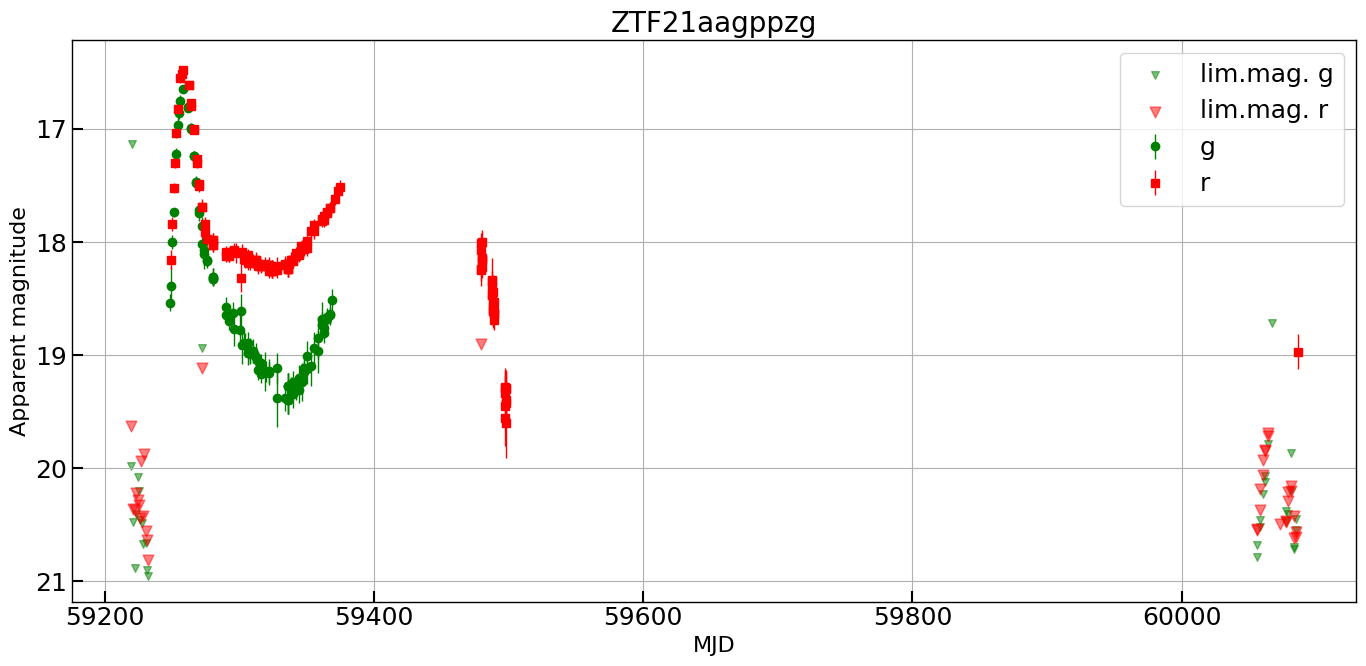

/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


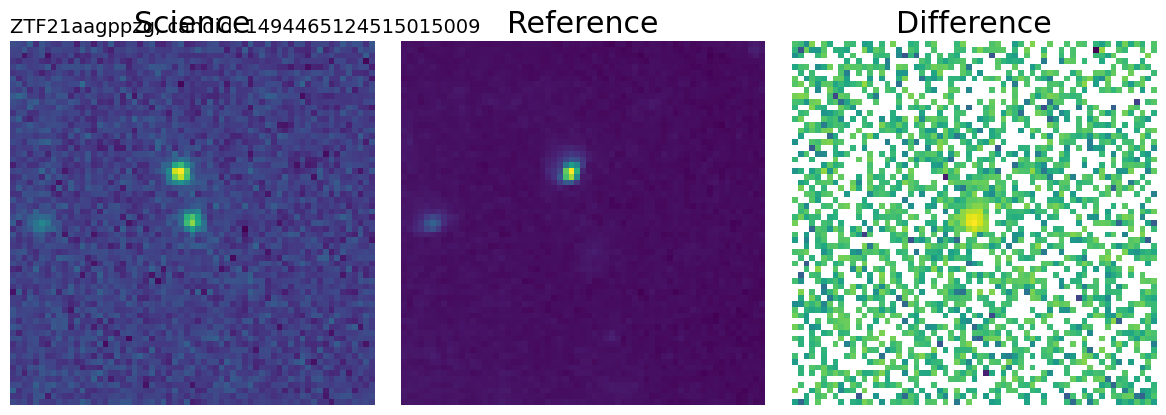

 33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

⚠️ Could not fetch detections for ZTF21aagyxgr: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


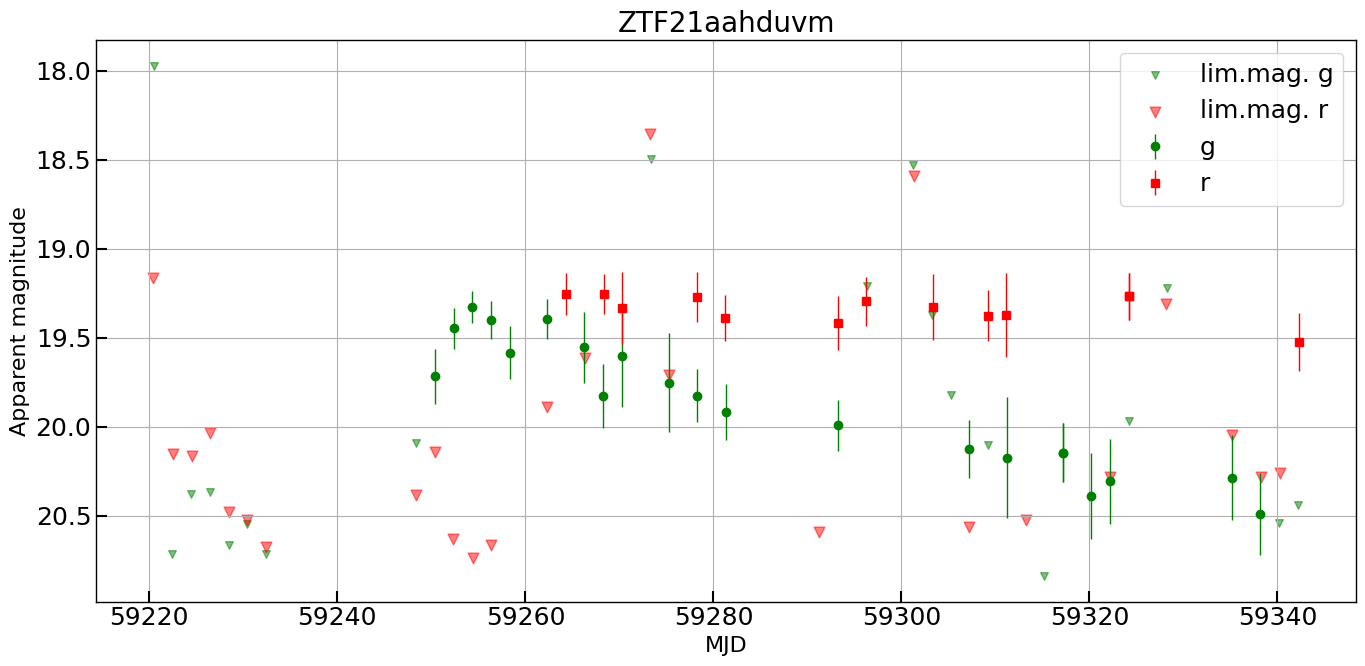

/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


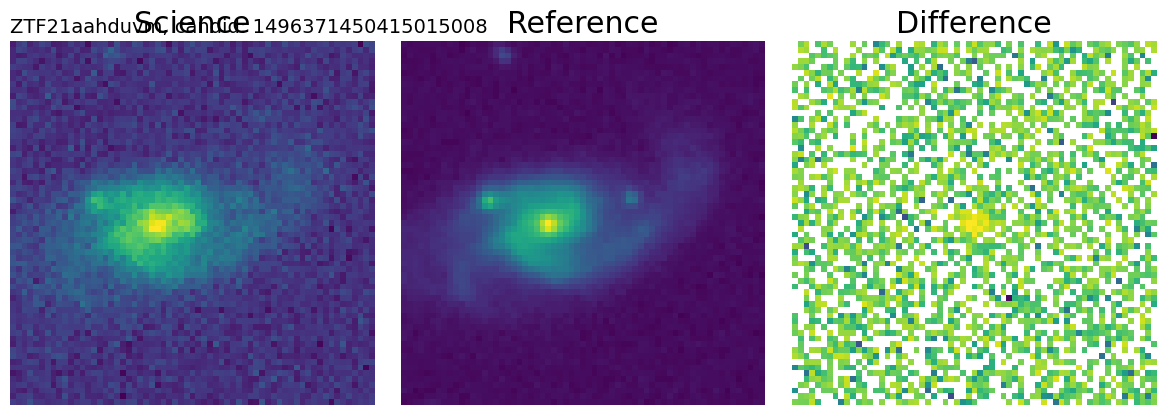

100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


In [150]:
# We have reduced the list from 450k to 4! Let us plot these sources to vet them and see which ones are further interesting.
for ind in tqdm(range(len(subluminous_alerts))):
    _ = get_lc_data(
        subluminous_alerts.iloc[ind]['oid'],
        alerce,
        doLC=True,
        doStamps=True
    )

Recall that Luminous Red Novae show a double peaked lightcurve that has a blue first peak followed by a second red peak. Do any of these transients follow this description?

We have successfully recovered the Luminous Red Nova ZTF21aagppzg / AT2021blu!!

There are still some contaminants despite all our filtering. How can you get rid of them?
- A few artifacts appear to be nuclear sources. These could be AGN. Xmatching to AGN catalogs would help here
- Some transients appear to be extremely long-lived. Some have unrealistic photometric scatter.
- Some transients remain blue throughout, unlike LRNe.

Note that these filtering steps that allowed us to identify this LRN all dealt with photometric data, without requiring any spectroscopic observations! Galaxy catalogs thus provide a powerful tool to search for low luminosity transients in Rubin data. LRNe are special cases as they show a characteristic lightcurve shape, so in principle they can be identified without any spectroscopic observations.

### Breakout 2 -
- Discuss what challenges you could face while doing this. Will the LSST cadence be an issue? What will be the major contaminants in this search?
- The ZTF discovery rate of LRNe is ~2-3 every year. What would the LRN discovery rate be with Rubin?



## 3. The diversity of low luminosity transients

We have seen how to identify a LRN in ZTF data. However, there are many other low luminosity transients that can be identified in a similar way. Let us look at the lightcurves of a few more classes of low luminosity transients, and see how they differ from LRNe.

Problem 3a : Look at the lightcurves of following transients in ZTF data:
- ZTF21aagppzg : LRN
- ZTF23aajlkxc : LRN
- ZTF19aadyppr : ILRT
- ZTF19acoaiub : ILRT
- ZTF21aagydmn : Possible LBV outburst
- ZTF21aaoryiz : Low luminosity Type Iax supernova


⚠️ Could not fetch non-detections for ZTF21aagppzg: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


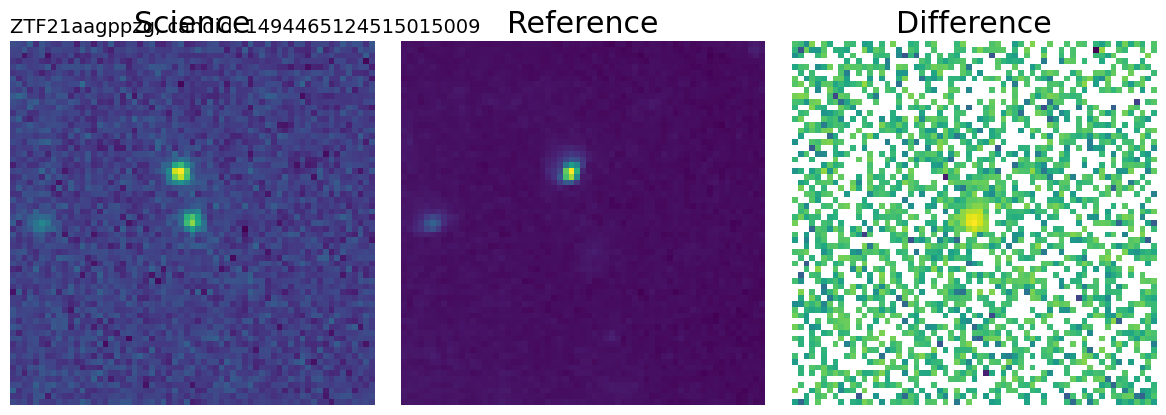

⚠️ Could not fetch non-detections for ZTF23aajlkxc: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability
/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


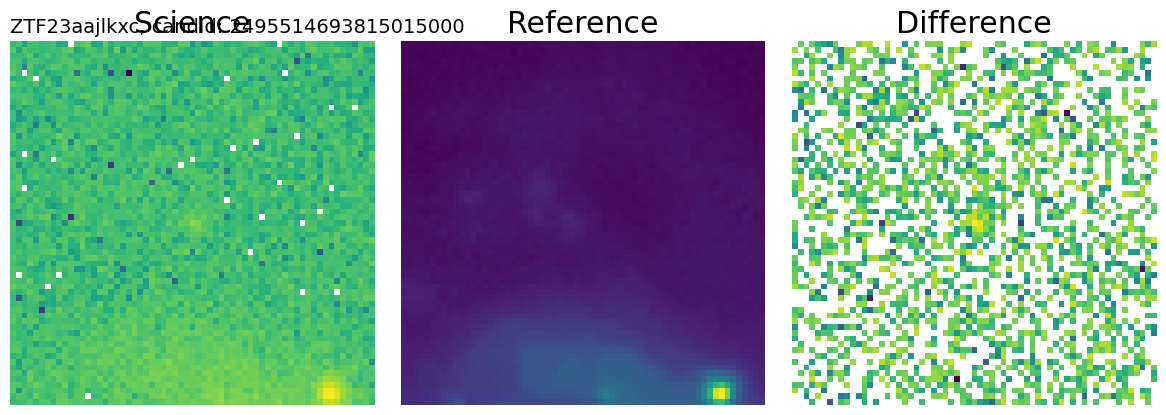

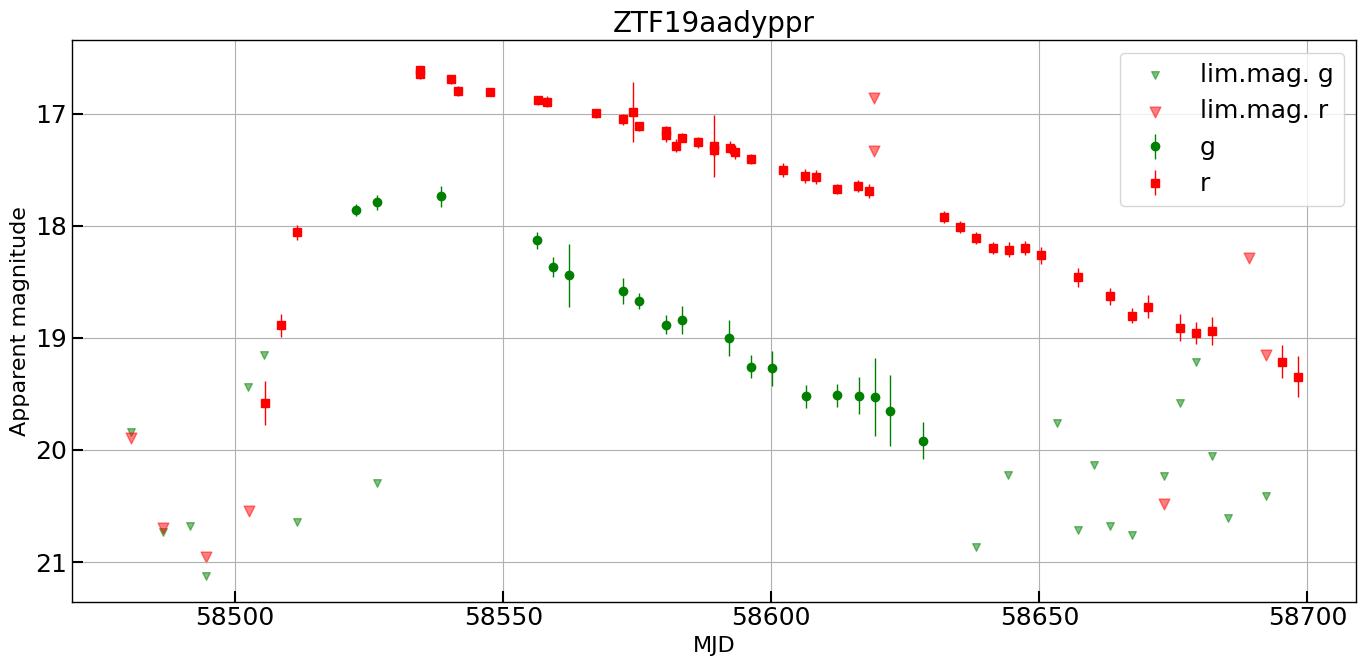

/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


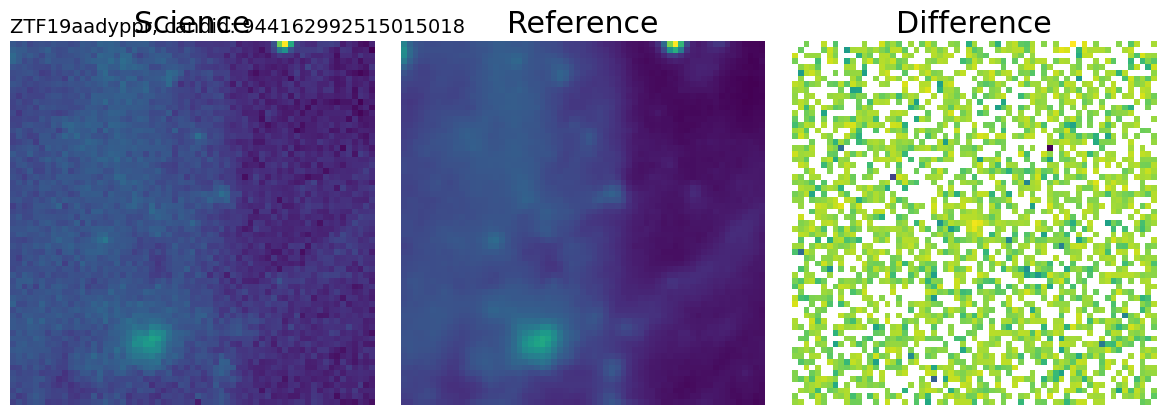

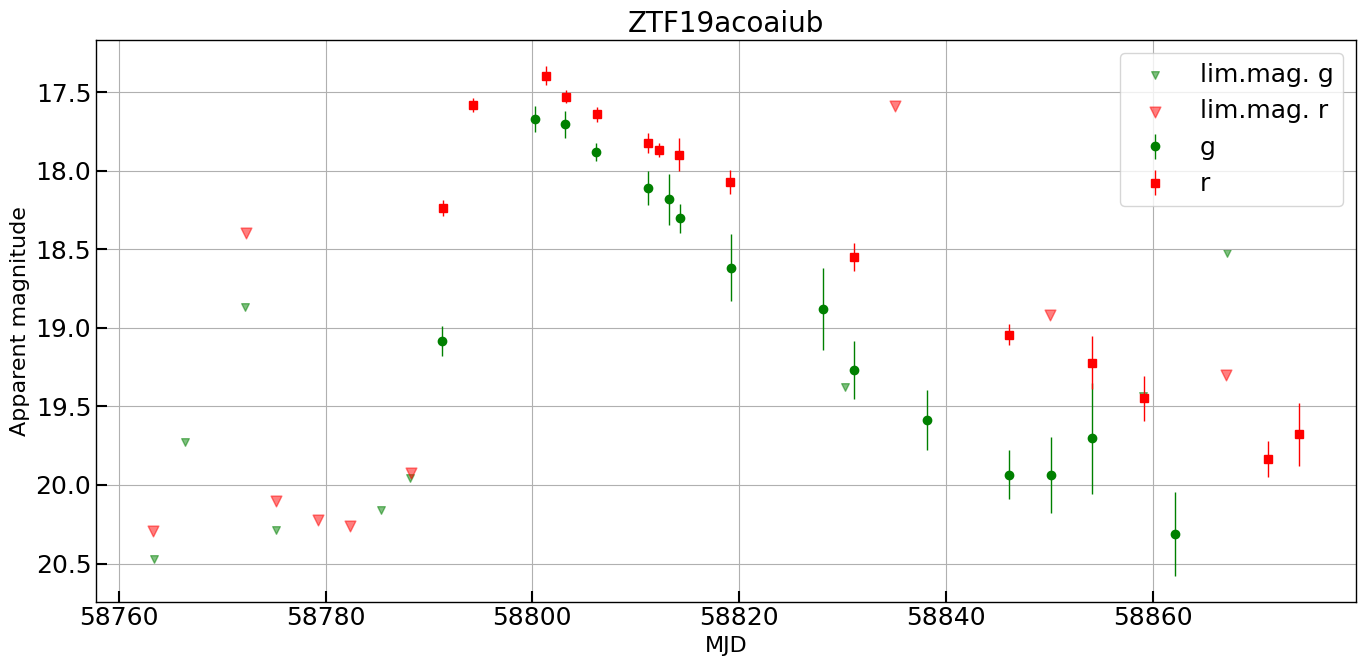

/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


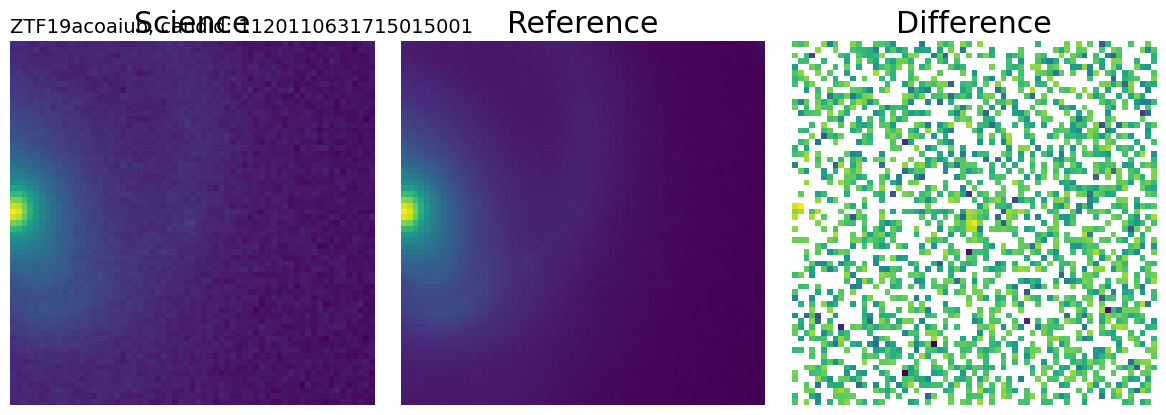

⚠️ Could not fetch non-detections for ZTF21aagydmn: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}


/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


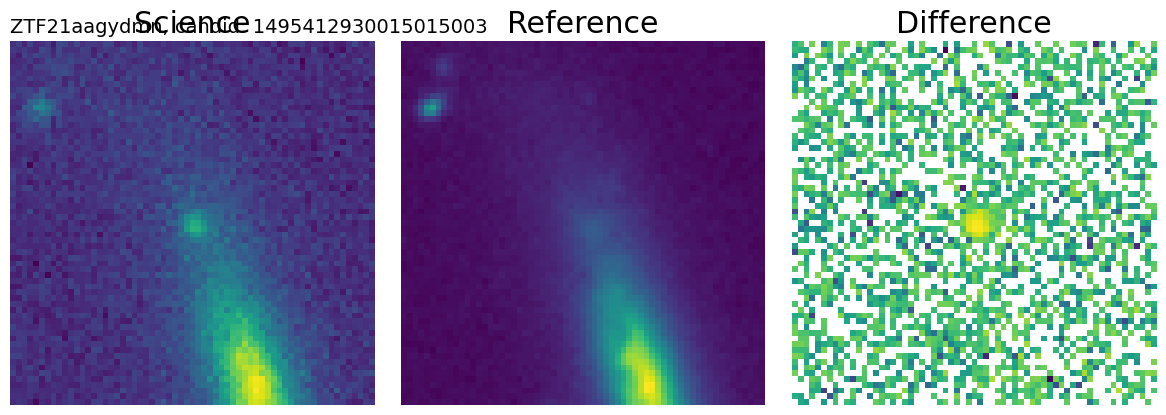

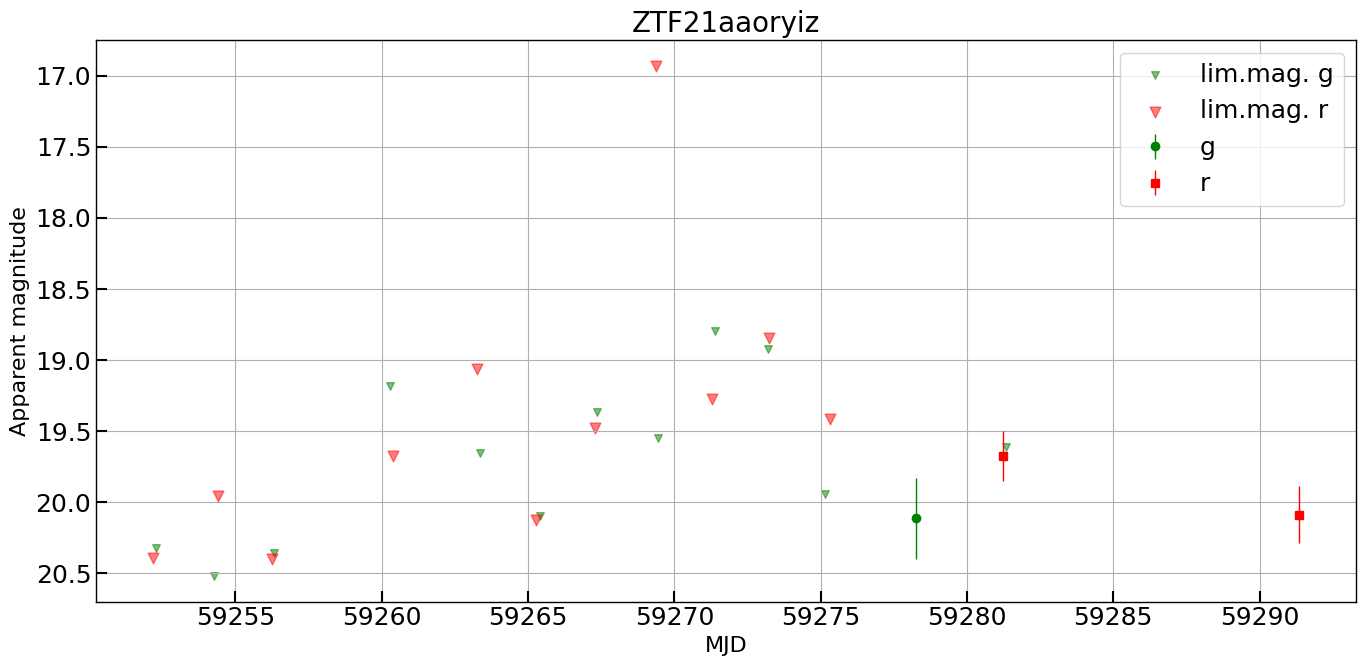

/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


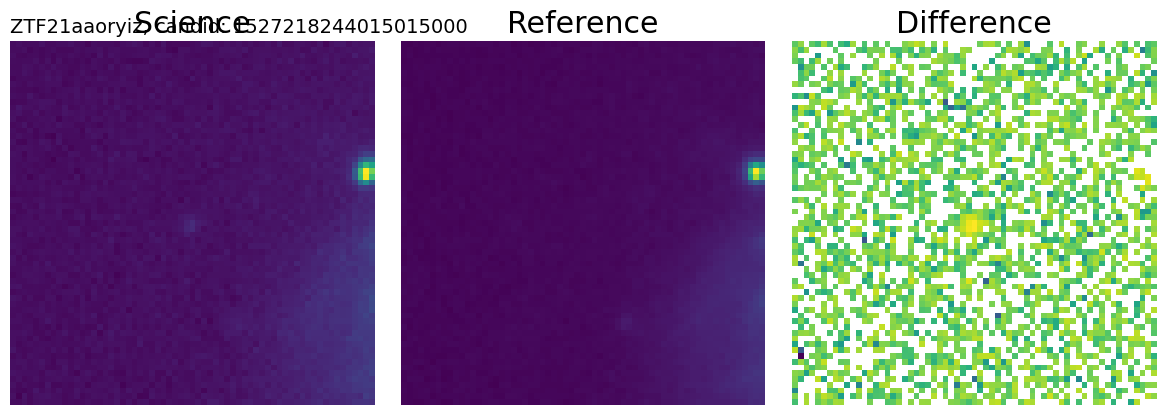

In [151]:
# Make lightcurve plots for the above sources
alerce = Alerce()
for name in ['ZTF21aagppzg', 'ZTF23aajlkxc', 'ZTF19aadyppr', 'ZTF19acoaiub', 'ZTF21aagydmn', 'ZTF21aaoryiz']:
    _ = get_lc_data(
        name,
        alerce,
        doLC=True,
        doStamps=True
    )


What differences do you see in these lightcurves?

- LRNe have a characteristic double peaked lightcurve, with a blue first peak followed by a red second peak.
- ILRTs have a single peaked lightcurve that is generally redder than LRNe.
- LBVs tend to be blue, however the dustiest LBV outbursts can also be red. In general, LBVs have multiple outbursts, so archival data from other surveys can be used to flag a candidate as a possible LBV.
- Low luminosity thermonuclear transients like SNe Iax tend to fade fast.

In my experience, of the different classes of low luminosity transients, LRNe are the easiest ones to identify photometrically. The other ones are .. less easy ..

## 4. Precursor emission
A benefit of focusing on nearby transients is that they allow searching for eruption preceding and after the main outburst. Let us look at an example to illustrate this.

Problem 4a : Examine the lightcurve of the Luminous Red Nova ZTF19adakuot. This source erupted in M31, (distance modulus of 24.5). ZTF missed majority of the main eruption due to visibility constraints, but the field was observed right up to a few days after the eruption. Plot the ZTF lightcurve of this transient.


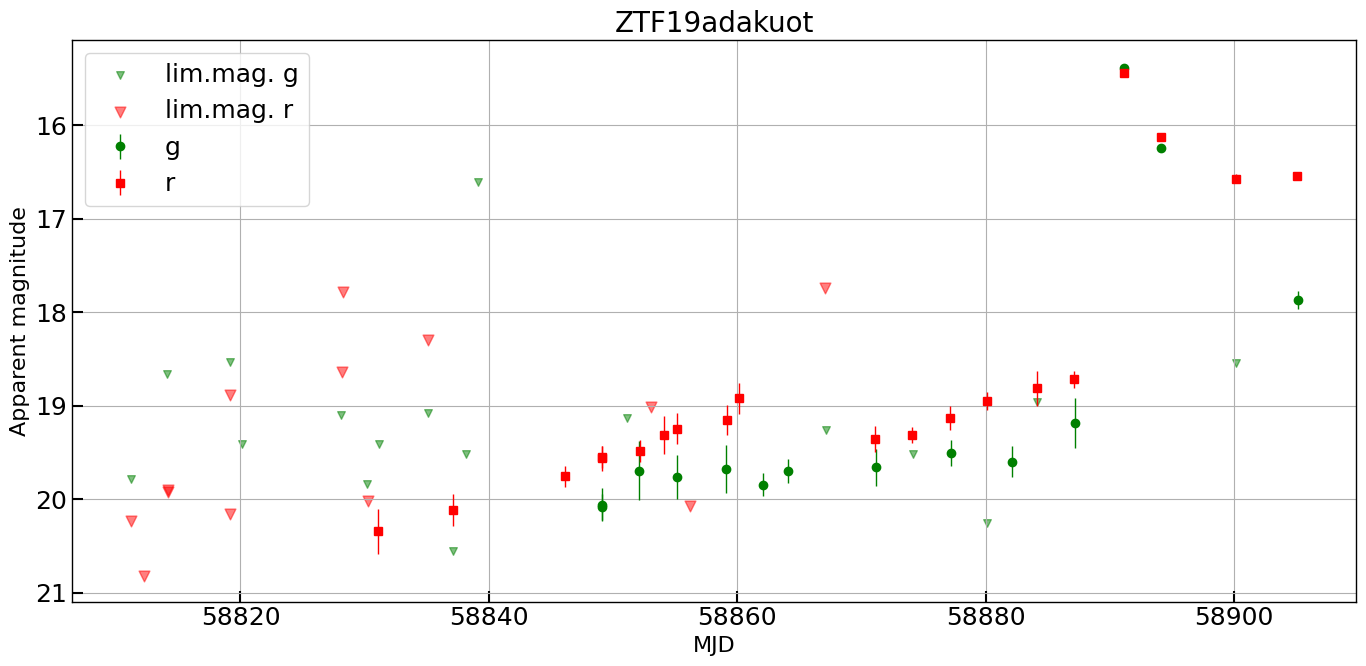

/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/1271849946.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


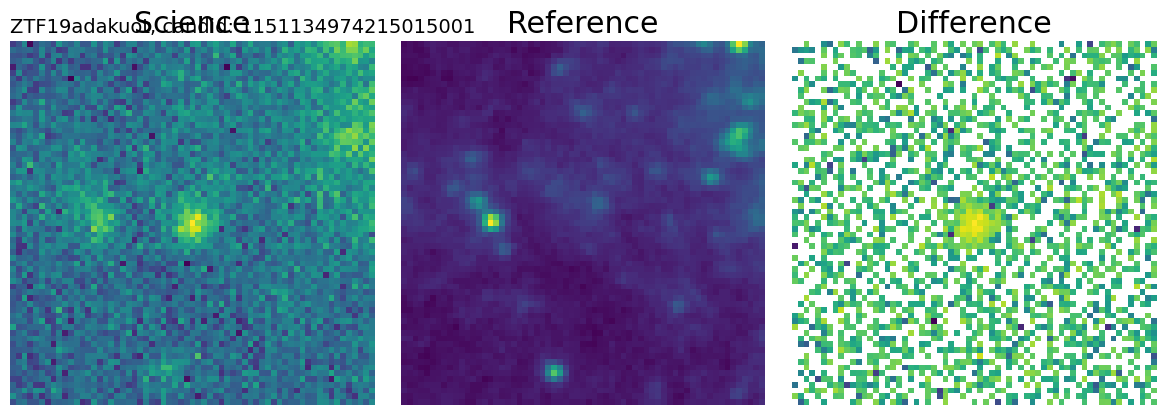

In [154]:
# Plot the lightcurve for ZTF19adakuot
alerce = Alerce()

_ = get_lc_data(
    "ZTF19adakuot",
    alerce,
    doLC=True,
    doStamps=True
)

We see the main eruption (absolute magnitude ~ -9) that starts off as blue and transitions rapidly to red colors. There are several detections preceding this! These precursor brightenings are believed to originate in outflows from the common-envelope prior to the merger, and thus they can tell us a lot about the common-envelope phase. However, such precursor detections are extremely rare! In fact, ZTF19adakuot is the only extragalactic LRN that has multiband precursor emission.

Problem 4b : What is the detection horizon limit for LRN precursor emission for a survey like ZTF? How does this compare to LSST? (Assume the precursors have similar luminosities as that for ZTF19adakuot)


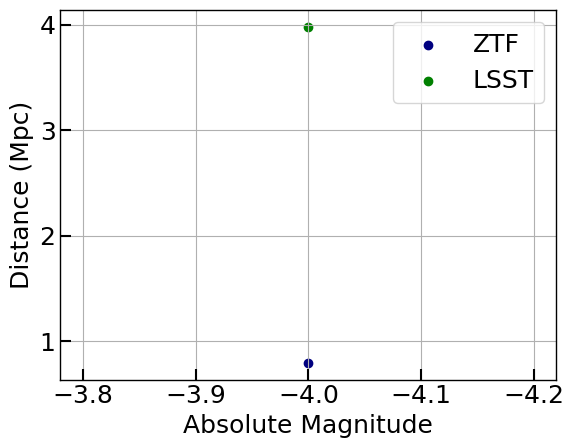

In [157]:
abs_mag = -4
ztf_lim_mag = 20.5
lsst_lim_mag = 24.0

ztf_distmod = ztf_lim_mag - abs_mags
lsst_distmod = lsst_lim_mag - abs_mags

ztf_dist = 10**((ztf_distmod + 5.) / 5.) / 1e6
lsst_dist = 10**((lsst_distmod + 5.) / 5.) / 1e6

plt.scatter(abs_mags, ztf_dist, label='ZTF', color='navy')
plt.scatter(abs_mags, lsst_dist, label='LSST', color='g')

plt.legend()
plt.ylabel('Distance (Mpc)')
plt.xlabel('Absolute Magnitude')
# plt.yscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [16]:
## Your code here

print(f"Detection horizon distance for precursor emission with ZTF: {ztf_dists:.2f}")
print(f"Detection horizon distance for precursor emission with LSST: {lsst_dists:.2f}")

## 5. Progenitor identifications

Another advantage of focusing on transients in nearby galaxies is they offer the possibility of looking at archival pre-eruption imaging to identify the progenitor system.

Let's go back to our original source ZTF21aagppzg. Check for pre-eruption images of ZTF21aagppzg. You can check for HST images [here](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html), or the Pan-STARRS images [here](https://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=&filter=color&filter=g&filter=r&filter=i&filter=z&filter=y&filetypes=stack&auxiliary=data&size=240&output_size=0&verbose=0&autoscale=99.500000&catlist=).

From Pastorello et al. 2022, the progenitor magnitudes of ZTF21aagppzg are :
$$M_{r}=-6.76 \pm 0.19$$

$$M_{g}=-6.49 \pm 0.26$$

$$M_{i}=-6.87 \pm 0.28$$

$$M_{z} = -6.89 \pm 0.35$$

Fit a blackbody to the SED of the progenitor star to estimate the temperature and luminosity of the progenitor primary star (assuming that the primary star dominates the flux measurements). Use a distance of $\approx 10$ Mpc for the host galaxy. You can use the fitting method of your choice.

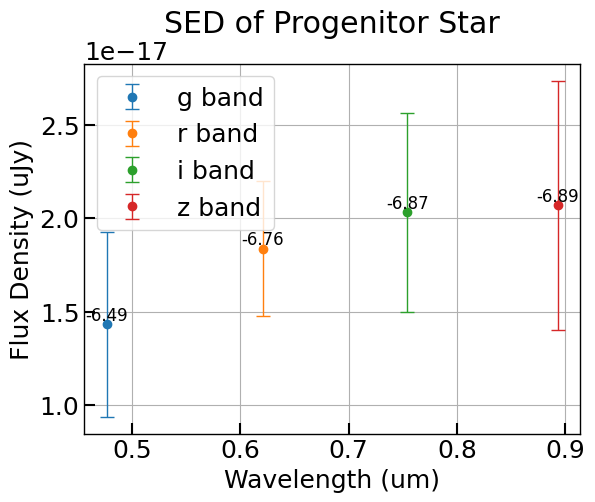

In [165]:
abs_mags = np.array([-6.49, -6.76, -6.87, -6.89])
abs_maguncs = np.array([0.26, 0.19, 0.28, 0.35])
wavs_um = np.array([0.477, 0.621, 0.754, 0.893])  # g, r, i, z in microns
D = 10 # Mpc

### Compute and plot the SED as fnu in uJy vs wavelength in micron
## Your code here

plt.subplots()
for i, (abs_mag, abs_magunc, wav_um) in enumerate(zip(abs_mags, abs_maguncs, wavs_um)):
    # Convert absolute magnitude to flux density in uJy
    fnu_ujy = 10**((abs_mag + 48.6) / -2.5)  # uJy
    fnu_unc = fnu * (abs_magunc / 1.0857)  # Convert magnitude uncertainty to flux density uncertainty

    # Convert wavelength from microns to meters for plotting
    # wav_m = wav_um

    plt.errorbar(wav_um, fnu_ujy, yerr=fnu_unc, fmt='o', label=f'{["g", "r", "i", "z"][i]} band', capsize=5)
    plt.text(wav_um, fnu_ujy, f'{abs_mag:.2f}', fontsize=12, ha='center', va='bottom') 
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux Density (uJy)')
plt.title('SED of Progenitor Star')
plt.legend()
plt.grid()
plt.show()

In [179]:
# Fit the blackbody to the data using emcee
def lnprior(theta):
    T, log_R = theta
    # Reasonable priors for stellar parameters
    if 2000 < T < 15000 and 10 < log_R < 15:  # Temperature in K, log radius in cm
        return 0.0
    return -np.inf


def lnlike(theta, wavs, fnu, fnu_unc, D=10 * 3.086e24):
    T, log_R = theta
    R = 10**log_R  # radius in cm
    
    # Convert wavelengths from microns to meters
    wavs_m = wavs * 1e-6
    
    # Create blackbody model using astropy
    bb = BlackBody(temperature=T * u.K)
    
    # Calculate flux density at Earth
    # F_nu = (R/D)^2 * B_nu(T)
    flux_model = (R / D)**2 * bb(wavs_m * u.m).to(u.erg / (u.s * u.cm**2 * u.Hz))
    
    # Convert to uJy
    flux_model_ujy = flux_model.to(u.microjansky).value
    
    # Calculate chi-squared
    chi2 = np.sum(((fnu - flux_model_ujy) / fnu_unc)**2)
    
    return -0.5 * chi2


def lnprob(theta, wavs, fnu, fnu_unc):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, wavs, fnu, fnu_unc)

In [180]:
nwalkers = 20
ndim = 2
initial = np.array([6800, 12])  # Initial guess for T and R
initial = np.random.normal(loc=initial, scale=[50, 12], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(wavs_um, fnu_ujy, fnu_unc))

sampler.run_mcmc(initial, 500, progress=True)

samples = sampler.get_chain(flat=True, discard=50)

fig = corner.corner(samples, labels=['T (K)', 'log10 R (cm)'], quantiles=[0.16, 0.5, 0.84], show_titles=True)


emcee: Exception while calling your likelihood function:
  params: [6808.43616065   13.79231645]
  args: (array([0.477, 0.621, 0.754, 0.893]), array([1.43218790e-17, 1.83653834e-17, 2.03235701e-17, 2.07014135e-17]), array([3.42975826e-18, 3.21398439e-18, 5.24141073e-18, 6.67356979e-18]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/nabeelr/miniforge3/envs/CCA-LSST/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/3049882697.py", line 37, in lnprob
    return lp + lnlike(theta, wavs, fnu, fnu_unc)
  File "/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_55422/3049882697.py", line 22, in lnlike
    flux_model = (R / D)**2 * bb(wavs_m * u.m).to(u.erg / (u.s * u.cm**2 * u.Hz))
  File "/Users/nabeelr/miniforge3/envs/CCA-LSST/lib/python3.10/site-packages/astropy/units/quantity.py", line 943, in to
    value = self._to_value(unit, equivalencies)
  File "/Users/nabeelr/miniforge3/envs/CCA-LSST/lib/python3.10/site-packages/astropy/units/quantity.py", line 896, in _to_value
    return self.unit.to(
  File "/Users/nabeelr/miniforge3/envs/CCA-LSST/lib/python3.10/site-packages/astropy/units/core.py", line 1228, in to
    return

UnitConversionError: 'erg / (Hz s sr cm2)' (surface brightness) and 'erg / (Hz s cm2)' (spectral flux density) are not convertible

In [168]:
print(f"Estimated temperature: {np.nanpercentile(samples[:, 0], [16, 50, 84])} K")
print(f"Estimated radius: {np.nanpercentile(samples[:, 1], [16, 50, 84])/7e10} Rsun")
lums = (4*np.pi* (samples[:, 1])**2 * 5.67e-5 * (samples[:, 0])**4)
print(f"Estimated luminosity: {np.nanpercentile(lums, [16, 50, 84])}")

Estimated temperature: [6664.08276177 6792.77191342 6863.90698123] K
Estimated radius: [2.35977296e-02 1.39795613e+02 1.89164166e+02] Rsun
Estimated luminosity: [4.02519052e+30 1.43531905e+38 2.52613220e+38]


Plot the luminosity and temperature on an HR diagram, and compare it to MIST stellar evolutionary tracks (look at the relevant tracks on https://waps.cfa.harvard.edu/MIST/model_grids.html#eeps) and derive constraints on the progenitor primary mass

In [48]:
# Helper functions to read MIST models
mist_colnames = ['star_age',
'star_mass',
'star_mdot',
'he_core_mass',
'c_core_mass',
'o_core_mass',
'log_L'      ,
'log_L_div_Ledd',
'log_LH'        ,
'log_LHe'       ,
'log_LZ'        ,
'log_Teff'      ,
'log_abs_Lgrav' ,
'log_R'         ,
'log_g'         ,
'log_surf_z'    ,
'surf_avg_omega',
'surf_avg_v_rot',
'surf_num_c12_div_num_o16',
'v_wind_Km_per_s'         ,
'surf_avg_omega_crit'   ,
'surf_avg_omega_div_omega_crit',
'surf_avg_v_crit'       ,
'surf_avg_v_div_v_crit' ,
'surf_avg_Lrad_div_Ledd',
'v_div_csound_surf',
'surface_h1'       ,
'surface_he3'      ,
'surface_he4'      ,
'surface_li7'      ,
'surface_be9'      ,
'surface_b11'      ,
'surface_c12'      ,
'surface_c13'      ,
'surface_n14'      ,
'surface_o16'      ,
'surface_f19'      ,
'surface_ne20'     ,
'surface_na23'     ,
'surface_mg24'     ,
'surface_si28'     ,
'surface_s32'      ,
'surface_ca40'     ,
'surface_ti48'     ,
'surface_fe56'     ,
'log_center_T'     ,
'log_center_Rho'   ,
'center_degeneracy',
'center_omega'     ,
'center_gamma'     ,
'mass_conv_core'   ,
'center_h1'        ,
'center_he4'       ,
'center_c12'       ,
'center_n14'       ,
'center_o16'       ,
'center_ne20'      ,
'center_mg24'      ,
'center_si28'      ,
'pp'               ,
'cno'              ,
'tri_alfa'         ,
'burn_c'           ,
'burn_n'           ,
'burn_o'           ,
'c12_c12'          ,
'delta_nu'         ,
'delta_Pg'         ,
'nu_max'           ,
'acoustic_cutoff'  ,
'max_conv_vel_div_csound',
'max_gradT_div_grada'    ,
'gradT_excess_alpha'     ,
'min_Pgas_div_P'         ,
'max_L_rad_div_Ledd'     ,
'e_thermal'              ,
'phase',]


def open_mist_model(filename):
    model = ascii.read(filename, names = mist_colnames)
    model = model[(model['phase']>=0)  & (model['phase']<=5)]
    return model

In [49]:
m10 = open_mist_model('files/mist_tracks/01000M.track.eep')
m11 = open_mist_model('files/mist_tracks/01100M.track.eep')
m12 = open_mist_model('files/mist_tracks/01200M.track.eep')
m13 = open_mist_model('files/mist_tracks/01300M.track.eep')
m14 = open_mist_model('files/mist_tracks/01400M.track.eep')
m15 = open_mist_model('files/mist_tracks/01500M.track.eep')
m16 = open_mist_model('files/mist_tracks/01600M.track.eep')
m17 = open_mist_model('files/mist_tracks/01700M.track.eep')

In [18]:
# Plot the MIST tracks on an HR diagram and overplot the LRN progenitor location
## Your code here

### Breakout 3:
In the Rubin era, what sources of archival data will be relevant? Review the specifications of the following missions and discuss their efficacy for archival progenitor identifications :
- Euclid
- HST/JWST
- Roman
- Rubin itself

### Bonus Problem :
For ZTF21aagppzg, compute the luminosity and the duration of the plateau phase, and use it to determine the total ejected mass using the recombination-powered lightcurve model given in [Matsumoto and Metzger 2022](https://arxiv.org/abs/2202.10478). How does the ejected mass compare to the progenitor mass you just derived above?